In [28]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr


In [29]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']

In [30]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


/var/folders/6_/dymf_8_d4fd5nxb42w_nwg_r0000gn/T/ipykernel_11035/3190214965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(subset=['player_age'], inplace=True)
/var/folders/6_/dymf_8_d4fd5nxb42w_nwg_r0000gn/T/ipykernel_11035/3190214965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['transfer_fee_amnt'].fillna(0, inplace=True)
/var/folders/6_/dymf_8_d4fd5nxb42w_nwg_r0000gn/T/ipykernel_11035/3190214965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [31]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


In [32]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno un arco in ingresso e uno in uscita 
selected_teams = [node for node in G.nodes() if out_degree[node] > 0 and in_degree[node] > 0 ] 

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  239  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  3  nodi con tutte le operazioni di mercato a 0
Nodi ->  236
Archi ->  11648
Density ->  0.21002524341868012


Matrice di adiacenza

In [33]:

nodes = list(net.nodes())
adj_matrix = np.zeros((len(nodes), len(nodes)))

for edge in net.edges():
    idx1 = nodes.index(edge[0])
    idx2 = nodes.index(edge[1])
    adj_matrix[idx1, idx2] = 1  # Se si tratta di un grafo non pesato

# Per grafi non diretti, potresti dover fare l'assegnazione anche in direzione opposta
adj_matrix += adj_matrix.T



In [34]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(adj_matrix)

cosine_sim

array([[1.        , 0.10166046, 0.17460757, ..., 0.22753405, 0.30242919,
        0.22524722],
       [0.10166046, 1.        , 0.04366669, ..., 0.17703091, 0.15126585,
        0.15200399],
       [0.17460757, 0.04366669, 1.        , ..., 0.04343722, 0.02886751,
        0.07678689],
       ...,
       [0.22753405, 0.17703091, 0.04343722, ..., 1.        , 0.10031397,
        0.5336655 ],
       [0.30242919, 0.15126585, 0.02886751, ..., 0.10031397, 1.        ,
        0.10639904],
       [0.22524722, 0.15200399, 0.07678689, ..., 0.5336655 , 0.10639904,
        1.        ]])

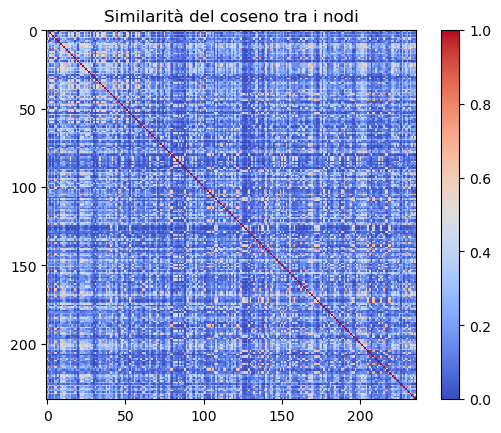

In [35]:
plt.imshow(cosine_sim, cmap='coolwarm', interpolation='nearest')
plt.title('Similarità del coseno tra i nodi')
plt.colorbar()
plt.show()


Top 10 nodi con similarità del coseno maggiore:
Nodo 383 (Club: PSV Eindhoven) - Coefficiente di Similarità: 1.0000000000000007
Nodo 379 (Club: West Ham United) - Coefficiente di Similarità: 1.0000000000000007
Nodo 984 (Club: West Bromwich Albion) - Coefficiente di Similarità: 1.0000000000000007
Nodo 2288 (Club: Swansea City) - Coefficiente di Similarità: 1.0000000000000007
Nodo 33 (Club: FC Schalke 04) - Coefficiente di Similarità: 1.0000000000000007
Nodo 720 (Club: FC Porto) - Coefficiente di Similarità: 1.0000000000000007
Nodo 31 (Club: Liverpool FC) - Coefficiente di Similarità: 1.0000000000000007
Nodo 3368 (Club: Levante UD) - Coefficiente di Similarità: 1.0000000000000007
Nodo 44 (Club: Hertha BSC) - Coefficiente di Similarità: 1.0000000000000007
Nodo 367 (Club: Rayo Vallecano) - Coefficiente di Similarità: 1.0000000000000004


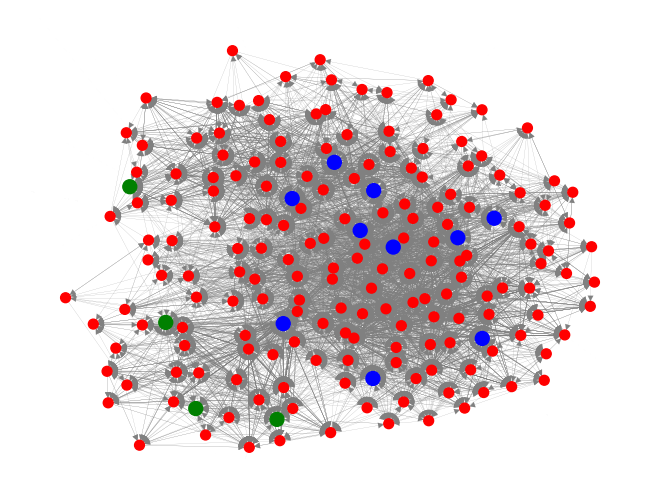

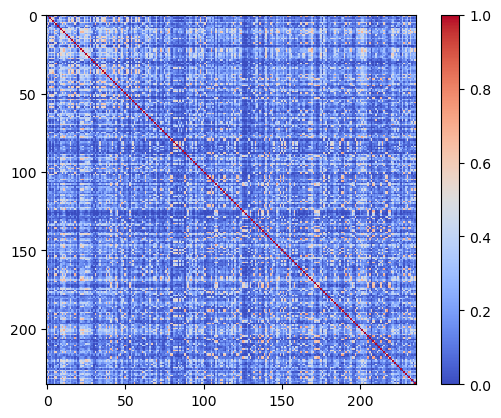

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

nodes = list(net.nodes())
adj_matrix = np.zeros((len(nodes), len(nodes)))

for edge in net.edges():
    idx1 = nodes.index(edge[0])
    idx2 = nodes.index(edge[1])
    adj_matrix[idx1, idx2] = 1  # Se si tratta di un grafo non pesato

# Per grafi non diretti, potresti dover fare l'assegnazione anche in direzione opposta
adj_matrix += adj_matrix.T

cosine_sim = cosine_similarity(adj_matrix)

# Ottieni i primi 10 e gli ultimi 10 nodi basati sulla similarità del coseno
sorted_indices = np.argsort(cosine_sim.flatten())[::-1]
top_10_indices = np.unravel_index(sorted_indices[:10], cosine_sim.shape)
bottom_10_indices = np.unravel_index(sorted_indices[-10:], cosine_sim.shape)

# Estrai i primi 10 e gli ultimi 10 nodi
top_10_nodes = [nodes[idx] for idx in top_10_indices[0]]
bottom_10_nodes = [nodes[idx] for idx in bottom_10_indices[0]]

# Crea un sottografo contenente i primi 10 e gli ultimi 10 nodi
top_bottom_subgraph = net.subgraph(top_10_nodes + bottom_10_nodes)

print("Top 10 nodi con similarità del coseno maggiore:")
for i, node in enumerate(top_10_nodes):
    club_name = net.nodes[node].get("name", "Nome sconosciuto")
    similarity_coefficient = cosine_sim[top_10_indices[0][i], top_10_indices[1][i]]
    print(f"Nodo {node} (Club: {club_name}) - Coefficiente di Similarità: {similarity_coefficient}")



# Estrai il sottografo completo che include tutti i nodi collegati ai nodi selezionati
full_subgraph = net.subgraph(list(top_bottom_subgraph.nodes) + [edge[1] for edge in net.edges(top_bottom_subgraph.nodes)])

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in full_subgraph.nodes:
    if node in top_10_nodes:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(100)  # Dimensione più grande per i nodi blu
    elif node in bottom_10_nodes:
        node_colors.append('green')  # Nodi ultimi 10
        node_sizes.append(100)  # Dimensione più grande per i nodi rossi
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(50)  # Dimensione più piccola per i nodi grigi

# Disegna il grafo completo senza etichette dei nodi
pos = nx.kamada_kawai_layout(full_subgraph)
nx.draw(full_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

#plt.title('Similarità del coseno tra i nodi')
plt.show()

plt.imshow(cosine_sim, cmap='coolwarm', interpolation='nearest')
#plt.title('Similarità del coseno tra i nodi')
plt.colorbar()
plt.show()

Top 10 nodi con coefficiente di Jaccard più alto:
Nodo 133 (Club: SC Cambuur-Leeuwarden) - Coefficiente di Jaccard: 0.6
Nodo 3327 (Club: FC Penafiel) - Coefficiente di Jaccard: 0.6
Nodo 3345 (Club: Leixões SC) - Coefficiente di Jaccard: 0.6
Nodo 798 (Club: Excelsior Rotterdam) - Coefficiente di Jaccard: 0.6
Nodo 1085 (Club: Vitória Setúbal FC) - Coefficiente di Jaccard: 0.5869565217391305
Nodo 979 (Club: Moreirense FC) - Coefficiente di Jaccard: 0.5869565217391305
Nodo 8024 (Club: FC Arouca) - Coefficiente di Jaccard: 0.5789473684210527
Nodo 1436 (Club: SC Beira-Mar) - Coefficiente di Jaccard: 0.5789473684210527
Nodo 1269 (Club: PEC Zwolle) - Coefficiente di Jaccard: 0.5652173913043478
Nodo 403 (Club: Willem II Tilburg) - Coefficiente di Jaccard: 0.5652173913043478


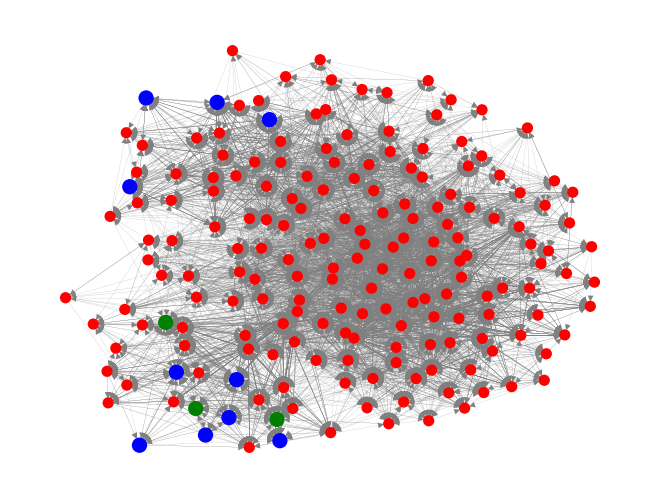

In [37]:
# Conversione in grafo non diretto
undirected_net = nx.Graph(net)

# Inizializzazione della lista vuota per i coefficienti di Jaccard
jaccard_coefficients = []

# Calcolo del coefficiente di Jaccard per tutte le coppie di nodi
for node in undirected_net.nodes():
    neighbors = set(undirected_net.neighbors(node))
    for nbr in undirected_net.nodes():
        if node != nbr:
            nbr_neighbors = set(undirected_net.neighbors(nbr))
            common_neighbors = neighbors.intersection(nbr_neighbors)
            union_neighbors = neighbors.union(nbr_neighbors)
            if len(union_neighbors) > 0:
                jaccard = len(common_neighbors) / len(union_neighbors)
                jaccard_coefficients.append((node, nbr, jaccard))

# Ordinamento dei coefficienti di Jaccard in ordine decrescente
sorted_coefficients = sorted(jaccard_coefficients, key=lambda x: x[2], reverse=True)

# Ottieni i primi 10 coefficienti
top_10_coefficients = sorted_coefficients[:10]

# Ottieni i nodi associati ai primi 10 coefficienti
top_10_nodes = [node for node, _, _ in top_10_coefficients]

# Creare un sottografo contenente i primi 10 nodi
top_subgraph = net.subgraph(top_10_nodes)

# Stampa il club e il coefficiente di Jaccard per i primi 10 nodi
print("Top 10 nodi con coefficiente di Jaccard più alto:")
for node, _, jaccard in top_10_coefficients:
    club_name = net.nodes[node].get("name", "Nome sconosciuto")
    print(f"Nodo {node} (Club: {club_name}) - Coefficiente di Jaccard: {jaccard}")

# Estrai il sottografo completo che include tutti i nodi collegati ai nodi selezionati
full_subgraph = net.subgraph(list(top_bottom_subgraph.nodes) + [edge[1] for edge in net.edges(top_bottom_subgraph.nodes)])

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in full_subgraph.nodes:
    if node in top_10_nodes:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(100)  # Dimensione più grande per i nodi blu
    elif node in bottom_10_nodes:
        node_colors.append('green')  # Nodi ultimi 10
        node_sizes.append(100)  # Dimensione più grande per i nodi rossi
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(50)  # Dimensione più piccola per i nodi grigi

# Disegna il grafo completo senza etichette dei nodi
pos = nx.kamada_kawai_layout(full_subgraph)
nx.draw(full_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

#plt.title('Coefficiente di Jaccard')
plt.show()


In [38]:
# Calcolare i gradi dei nodi
degrees = dict(net.degree())

edge_degrees = [(degrees[u], degrees[v]) for u, v in net.edges()]

degrees_x, degrees_y = zip(*edge_degrees)  # Correzione dell'estrazione dei gradi

correlation_coefficient, p_value = pearsonr(degrees_x, degrees_y)
print(f"Pearson correlation coefficient: {correlation_coefficient}, p-value: {p_value}")
'''
plt.scatter(degrees_x, degrees_y)
plt.xlabel('Degrees of Node X')
plt.ylabel('Degrees of Node Y')
plt.title('Correlation between Connected Node Degrees')
plt.show()
'''

Pearson correlation coefficient: 0.23242324298676686, p-value: 1.1508707136474775e-142


"\nplt.scatter(degrees_x, degrees_y)\nplt.xlabel('Degrees of Node X')\nplt.ylabel('Degrees of Node Y')\nplt.title('Correlation between Connected Node Degrees')\nplt.show()\n"

In [44]:
def hamming_distance(net, node1, node2):
    neighbors_node1 = set(net.neighbors(node1))
    neighbors_node2 = set(net.neighbors(node2))
    return len(neighbors_node1.symmetric_difference(neighbors_node2))

# Calcolo della distanza di Hamming per tutte le coppie di nodi nel grafo
hamming_distances = {}
for node1 in net.nodes():
    distance = 0
    for node2 in net.nodes():
        if node1 != node2:
            distance = hamming_distance(net, node1, node2)
            hamming_distances[node1] = distance

# Ordina i nodi in base alla distanza di Hamming in ordine decrescente
sorted_nodes = sorted(hamming_distances.items(), key=lambda x: x[1], reverse=True)

# Ottieni i primi 10 nodi con la distanza di Hamming più elevata
top_10_nodes = [node for node, _ in sorted_nodes[:10]]
bottom_10_nodes = [node for node, _ in sorted_nodes[-10:]]

# Estrai i primi 10 e gli ultimi 10 nodi con la distanza di Hamming più elevata
top_10_nodes = [node for node, _ in sorted_nodes[:10]]
bottom_10_nodes = [node for node, _ in sorted_nodes[-10:]]

# Creare un sottografo contenente i primi 10 e gli ultimi 10 nodi
top_bottom_subgraph = net.subgraph(top_10_nodes + bottom_10_nodes)

print("Top 10 nodi con distanza di Hamming più alta:")
for node in top_10_nodes:
    club_name = top_bottom_subgraph.nodes[node].get("name", "Nome sconosciuto")
    print(f"Nodo {node} (Club: {club_name})")


Top 10 nodi con distanza di Hamming più alta:
Nodo 631 (Club: Chelsea FC)
Nodo 162 (Club: AS Monaco)
Nodo 294 (Club: SL Benfica)
Nodo 506 (Club: Juventus FC)
Nodo 281 (Club: Manchester City)
Nodo 336 (Club: Sporting CP)
Nodo 46 (Club: FC Internazionale)
Nodo 720 (Club: FC Porto)
Nodo 5 (Club: AC Milan)
Nodo 82 (Club: VfL Wolfsburg)


In [45]:
def hamming_distance(net, node1, node2):
    neighbors_node1 = set(net.neighbors(node1))
    neighbors_node2 = set(net.neighbors(node2))
    return len(neighbors_node1.symmetric_difference(neighbors_node2))

# Calcolo della distanza di Hamming per tutte le coppie di nodi nel grafo
hamming_distances = {}
for node1 in net.nodes():
    distances_for_node1 = {}
    for node2 in net.nodes():
        if node1 != node2:
            distance = hamming_distance(net, node1, node2)
            distances_for_node1[node2] = distance
    hamming_distances[node1] = distances_for_node1

# Ordina i nodi in base alla distanza di Hamming in ordine decrescente
sorted_nodes = sorted(hamming_distances.items(), key=lambda x: max(x[1].values()), reverse=True)

# Ottieni i primi 10 nodi con la distanza di Hamming più elevata
top_10_nodes = [node for node, _ in sorted_nodes[:10]]
bottom_10_nodes = [node for node, _ in sorted_nodes[-10:]]

# Estrai i primi 10 e gli ultimi 10 nodi con la distanza di Hamming più elevata
top_bottom_subgraph = net.subgraph(top_10_nodes + bottom_10_nodes)

print("Top 10 nodi con distanza di Hamming più alta:")
for node, distances_for_node in sorted_nodes[:10]:
    club_name = top_bottom_subgraph.nodes[node].get("name", "Nome sconosciuto")
    max_distance = max(distances_for_node.values())
    print(f"Nodo {node} (Club: {club_name}) - Distanza di Hamming massima: {max_distance}")


Top 10 nodi con distanza di Hamming più alta:
Nodo 336 (Club: Sporting CP) - Distanza di Hamming massima: 113
Nodo 383 (Club: PSV Eindhoven) - Distanza di Hamming massima: 113
Nodo 631 (Club: Chelsea FC) - Distanza di Hamming massima: 108
Nodo 294 (Club: SL Benfica) - Distanza di Hamming massima: 108
Nodo 347 (Club: FC Metz) - Distanza di Hamming massima: 108
Nodo 15 (Club: Bayer 04 Leverkusen) - Distanza di Hamming massima: 107
Nodo 1075 (Club: SC Braga) - Distanza di Hamming massima: 106
Nodo 720 (Club: FC Porto) - Distanza di Hamming massima: 106
Nodo 2420 (Club: Vitória Guimarães SC) - Distanza di Hamming massima: 106
Nodo 24 (Club: Eintracht Frankfurt) - Distanza di Hamming massima: 104


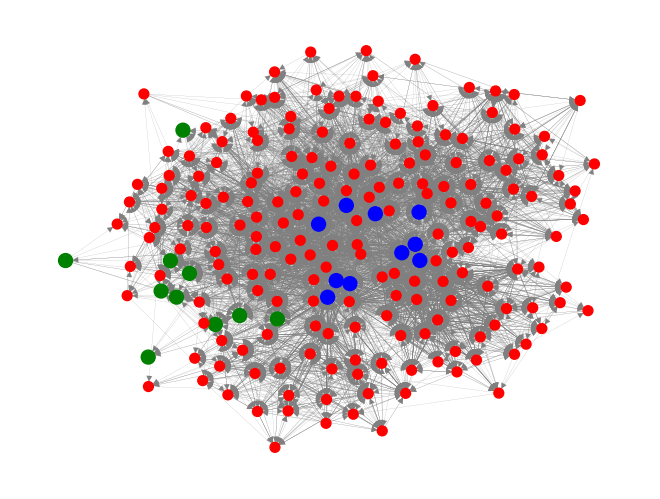

In [40]:
'''
# Ottenere il layout per il disegno del grafo
pos = nx.kamada_kawai_layout(net)

nx.draw(top_10_subgraph, pos, with_labels=True, node_size=300)

# Mostrare il grafico
plt.title('Hamming distance')
plt.show()
'''
# Estrai il sottografo completo che include tutti i nodi collegati ai nodi selezionati
full_subgraph = net.subgraph(list(top_bottom_subgraph.nodes) + [edge[1] for edge in net.edges(top_bottom_subgraph.nodes)])

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in full_subgraph.nodes:
    if node in top_10_nodes:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(100)  # Dimensione più grande per i nodi blu
    elif node in bottom_10_nodes:
        node_colors.append('green')  # Nodi ultimi 10
        node_sizes.append(100)  # Dimensione più grande per i nodi rossi
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(50)  # Dimensione più piccola per i nodi grigi

# Disegna il grafo completo senza etichette dei nodi
pos = nx.kamada_kawai_layout(full_subgraph)
nx.draw(full_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

#plt.title('Distanza di Hamming')
plt.show()


I primi 10 nodi con l'equivalenza regolare più alta:
Nodo 46 (Club: FC Internazionale)
Nodo 12 (Club: AS Roma)
Nodo 506 (Club: Juventus FC)
Nodo 5 (Club: AC Milan)
Nodo 252 (Club: Genoa CFC)
Nodo 1038 (Club: UC Sampdoria)
Nodo 410 (Club: Udinese Calcio)
Nodo 130 (Club: Parma Calcio 1913)
Nodo 720 (Club: FC Porto)
Nodo 294 (Club: SL Benfica)


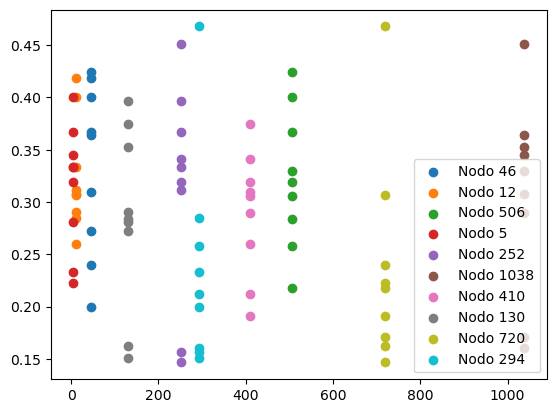

In [41]:
import networkx as nx

def regular_equivalence(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1))
    neighbors2 = set(graph.neighbors(node2))
    
    common_neighbors = neighbors1.intersection(neighbors2)
    
    if len(common_neighbors) == 0:
        return 0.0
    
    all_neighbors = neighbors1.union(neighbors2)
    
    return len(common_neighbors) / len(all_neighbors)

# Calcola la centralità dei nodi (grado) e seleziona i primi 10 nodi più importanti
top_nodes = sorted(net.degree, key=lambda x: x[1], reverse=True)[:10]

equivalences = {}
for node, _ in top_nodes:
    # Calcola l'equivalenza regolare rispetto agli altri nodi
    equivalences[node] = sum(regular_equivalence(net, node, other_node) for other_node, _ in top_nodes if other_node != node)

# Trova i 10 nodi con l'equivalenza regolare più alta
top_10_equivalent_nodes = sorted(equivalences, key=equivalences.get, reverse=True)[:10]

# Creare un sottografo contenente solo i primi 10 nodi
top_10_subgraph = net.subgraph(top_10_equivalent_nodes)

print("I primi 10 nodi con l'equivalenza regolare più alta:")
for node in top_10_equivalent_nodes:
    club_name = top_10_subgraph.nodes[node].get("name", "Nome sconosciuto")
    print(f"Nodo {node} (Club: {club_name})")

# Visualizzazione dell'equivalenza regolare dei 10 nodi più importanti
for node in top_10_equivalent_nodes:
    eq_values = [regular_equivalence(net, node, other_node) for other_node, _ in top_nodes if other_node != node]
    plt.scatter([node] * len(eq_values), eq_values, label=f'Nodo {node}')

#plt.xlabel('Nodo')
#plt.ylabel('Equivalenza regolare')
#plt.title('Equivalenza regolare dei 10 nodi più importanti rispetto agli altri')
plt.legend()
plt.show()


Squadra: Bologna FC 1909 - Numero di 'cliques' collegati: 10
Squadra: AS Roma - Numero di 'cliques' collegati: 10
Squadra: SSC Napoli - Numero di 'cliques' collegati: 10
Squadra: ACF Fiorentina - Numero di 'cliques' collegati: 10
Squadra: AC Milan - Numero di 'cliques' collegati: 10
Squadra: FC Internazionale - Numero di 'cliques' collegati: 10
Squadra: Torino FC - Numero di 'cliques' collegati: 10
Squadra: Atalanta BC - Numero di 'cliques' collegati: 10
Squadra: Juventus FC - Numero di 'cliques' collegati: 10
Squadra: Chievo Verona - Numero di 'cliques' collegati: 10
Squadra: Parma Calcio 1913 - Numero di 'cliques' collegati: 10
Squadra: US Palermo - Numero di 'cliques' collegati: 8
Squadra: Empoli FC - Numero di 'cliques' collegati: 10
Squadra: Cagliari Calcio - Numero di 'cliques' collegati: 10
Squadra: Udinese Calcio - Numero di 'cliques' collegati: 5
Squadra: Brescia Calcio - Numero di 'cliques' collegati: 6
Squadra: Genoa CFC - Numero di 'cliques' collegati: 6
Squadra: US Lecce -

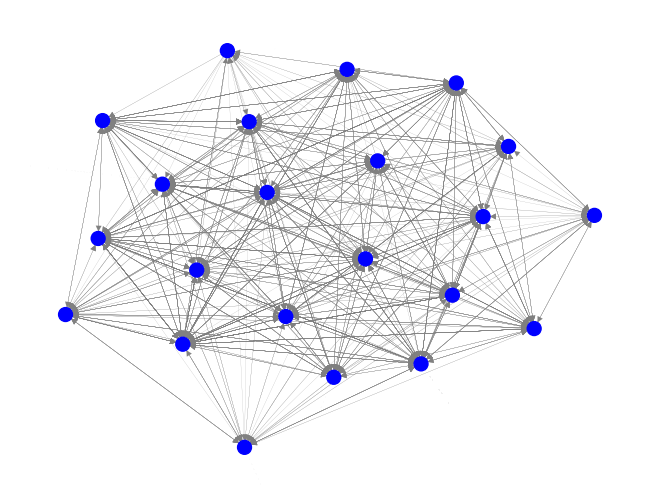

In [48]:
# Converti il grafo diretto in uno non diretto
grafo_non_diretto = net.to_undirected()

# Trova i "cliques" nel grafo non diretto
cliques = list(nx.find_cliques(grafo_non_diretto))

# Calcoliamo e ordiniamo i cliques in base alla grandezza (numero di nodi)
cliques_with_size = [(clique, len(clique)) for clique in cliques]
sorted_cliques = sorted(cliques_with_size, key=lambda x: x[1], reverse=True)

# I primi 10 cliques più importanti
top_10_cliques = sorted_cliques[:10]

# Estrai i nodi più importanti dai cliques calcolati
top_10_nodes = [node for clique, _ in top_10_cliques for node in clique]

# Creare un dizionario per contare i "cliques" collegati a ciascuna squadra
cliques_per_team = defaultdict(int)

# Contare i "cliques" collegati a ciascuna squadra tra i primi 10 nodi
for clique, _ in top_10_cliques:
    for node in clique:
        club_name = net.nodes[node]['name']
        cliques_per_team[club_name] += 1

# Stampare il numero di "cliques" collegati a ciascuna squadra nei primi 10 nodi
for club, num_cliques in cliques_per_team.items():
    print(f"Squadra: {club} - Numero di 'cliques' collegati: {num_cliques}")

# Creare un sottografo contenente i primi 10 nodi
top_subgraph = net.subgraph(top_10_nodes)

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in top_subgraph.nodes:
    if node in top_10_nodes:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(100)  # Dimensione più grande per i nodi blu
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(50)  # Dimensione più piccola per i nodi grigi

# Disegna il sottografo dei primi 10 nodi senza etichette dei nodi
pos = nx.kamada_kawai_layout(top_subgraph)
nx.draw(top_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

# plt.title('Clique')
plt.show()


Nodo 512 - Core Number: 30 - Club: Stoke City
Nodo 3 - Core Number: 30 - Club: 1. FC Köln
Nodo 5 - Core Number: 30 - Club: AC Milan
Nodo 11 - Core Number: 30 - Club: Arsenal FC
Nodo 12 - Core Number: 30 - Club: AS Roma
Nodo 13 - Core Number: 30 - Club: Atlético de Madrid
Nodo 1038 - Core Number: 30 - Club: UC Sampdoria
Nodo 16 - Core Number: 30 - Club: Borussia Dortmund
Nodo 1041 - Core Number: 30 - Club: Olympique Lyon
Nodo 15 - Core Number: 30 - Club: Bayer 04 Leverkusen


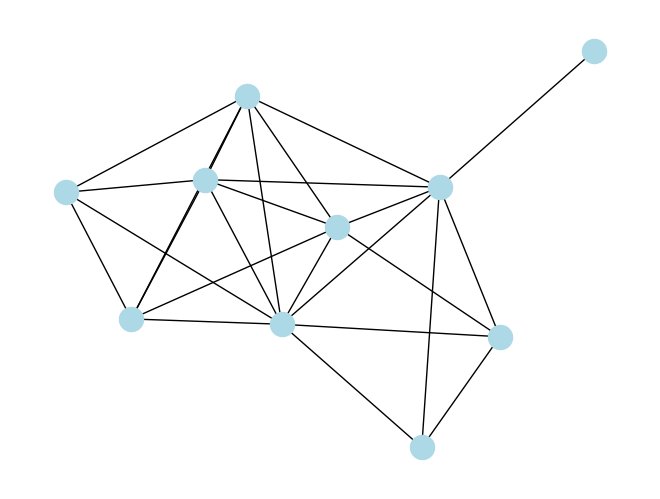

In [43]:
# Identifica e rimuovi gli archi self-loop
self_loop_edges = [(u, v) for u, v in net.edges() if u == v]
net.remove_edges_from(self_loop_edges)

# Calcolo dei k-cores nel grafo semplificato
simple_graph = nx.Graph(net)
k_cores = nx.core_number(simple_graph)

# Ordina i nodi in base al core number in ordine decrescente
sorted_cores = sorted(k_cores.items(), key=lambda x: x[1], reverse=True)

# Estrai i primi 10 nodi con i k-core più alti
top_10_nodes = sorted_cores[:10]

# Crea un dizionario per mappare i nodi con i loro k-cores
top_10_dict = {node: core for node, core in top_10_nodes}

# Estrai il sottografo contenente solo i primi 10 nodi
top_10_subgraph = simple_graph.subgraph(top_10_dict.keys())

# Stampare i k-cores e il nome del club per ogni nodo nei primi 10 nodi con i k-core più alti
for node, core_number in top_10_dict.items():
    club_name = net.nodes[node]['name']
    print(f"Nodo {node} - Core Number: {core_number} - Club: {club_name}")


# Disegna solo i primi 10 nodi con i k-core più alti
pos = nx.kamada_kawai_layout(top_10_subgraph)  # Posizioni dei nodi
nx.draw(top_10_subgraph, pos, node_color='lightblue', with_labels=False)
#plt.title('Primi 10 nodi con k-core più alto')
plt.show()


-------------------